In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mutual_info_score

import xgboost as xgb

from IPython.display import display

# Data Preparation

In [2]:
df = pd.read_csv('./data/kaggle.com/umuttuygurr/e-commerce-fraud-detection-dataset/transactions.csv')
df.shape

(299695, 17)

In [3]:
df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [4]:
df.dtypes

transaction_id               int64
user_id                      int64
account_age_days             int64
total_transactions_user      int64
avg_amount_user            float64
amount                     float64
country                     object
bin_country                 object
channel                     object
merchant_category           object
promo_used                   int64
avs_match                    int64
cvv_result                   int64
three_ds_flag                int64
transaction_time            object
shipping_distance_km       float64
is_fraud                     int64
dtype: object

### Check for null values

In [5]:
df.isnull().sum()

transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

### Check for duplicates

In [6]:
df.duplicated().sum()

np.int64(0)

### Parse transaction time to extract derived data

In [7]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
df['day'] = df['transaction_time'].dt.dayofweek
df['month'] = df['transaction_time'].dt.month
df['hour'] = df['transaction_time'].dt.hour
# Define night hours (e.g., 10 PM to 5 AM)
df['night_hours'] = ((df['hour'] >= 22) | (df['hour'] < 5)).astype(int)

### Drop unnecessary columns

In [8]:
del df['transaction_id']
del df['transaction_time']

### Setting up Validation Framework

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.is_fraud.values
y_val = df_val.is_fraud.values
y_test = df_test.is_fraud.values

del df_train['is_fraud']
del df_val['is_fraud']
del df_test['is_fraud']

# Exploratory data analysis (EDA)

In [10]:
categorical = ['country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'night_hours']
numerical = ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'month', 'day', 'hour']

In [11]:
for col in categorical:
    print(col)
    print(df_full_train[col].unique())
    print()

country
['TR' 'DE' 'NL' 'FR' 'PL' 'RO' 'ES' 'US' 'GB' 'IT']

bin_country
['GB' 'DE' 'NL' 'FR' 'PL' 'RO' 'ES' 'US' 'TR' 'IT']

channel
['web' 'app']

merchant_category
['fashion' 'travel' 'grocery' 'gaming' 'electronics']

promo_used
[1 0]

avs_match
[1 0]

cvv_result
[1 0]

three_ds_flag
[1 0]

night_hours
[1 0]



### Fraud rate by categorical features

In [12]:
global_fraud_rate = df_full_train.is_fraud.mean()

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).is_fraud.agg(['mean', 'count'])
    df_group['diff'] = round(df_group['mean'] - global_fraud_rate, 4)
    df_group['risk'] = round(df_group['mean'] / global_fraud_rate, 4)
    display(df_group)
    print()
    print()

country


,mean,count,diff,risk
country,,,,
DE,0.016166,23197,-0.0056,0.7422
ES,0.022826,23088,0.0010,1.0480
FR,0.021876,24182,0.0001,1.0044
GB,0.020881,24520,-0.0009,0.9587
IT,0.021160,22921,-0.0006,0.9715
NL,0.017352,24205,-0.0044,0.7967
PL,0.022754,24084,0.0010,1.0447
RO,0.024161,23592,0.0024,1.1093
TR,0.027529,24011,0.0057,1.2639




bin_country


,mean,count,diff,risk
bin_country,,,,
DE,0.017541,23260,-0.0042,0.8053
ES,0.022409,23205,0.0006,1.0289
FR,0.021251,24093,-0.0005,0.9757
GB,0.021637,24495,-0.0001,0.9934
IT,0.022223,22994,0.0004,1.0203
NL,0.019332,24260,-0.0024,0.8876
PL,0.023237,24099,0.0015,1.0669
RO,0.023182,23639,0.0014,1.0643
TR,0.025716,23876,0.0039,1.1807




channel


,mean,count,diff,risk
channel,,,,
app,0.007881,118125,-0.0139,0.3619
web,0.035279,121631,0.0135,1.6197




merchant_category


,mean,count,diff,risk
merchant_category,,,,
electronics,0.022385,48291,0.0006,1.0278
fashion,0.022331,47781,0.0006,1.0253
gaming,0.021189,47855,-0.0006,0.9728
grocery,0.020183,47861,-0.0016,0.9267
travel,0.022807,47968,0.0010,1.0471




promo_used


,mean,count,diff,risk
promo_used,,,,
0,0.017593,202870,-0.0042,0.8077
1,0.044814,36886,0.0230,2.0575




avs_match


,mean,count,diff,risk
avs_match,,,,
0,0.096235,38915,0.0745,4.4184
1,0.007354,200841,-0.0144,0.3376




cvv_result


,mean,count,diff,risk
cvv_result,,,,
0,0.106273,30685,0.0845,4.8793
1,0.009380,209071,-0.0124,0.4306




three_ds_flag


,mean,count,diff,risk
three_ds_flag,,,,
0,0.066816,51679,0.0450,3.0677
1,0.009406,188077,-0.0124,0.4318




night_hours


,mean,count,diff,risk
night_hours,,,,
0,0.02162,169752,-0.0002,0.9926
1,0.02217,70004,0.0004,1.0179


### Mutual information

In [13]:
def is_fraud_mutual_info_score(series):
    return mutual_info_score(series, df_full_train.is_fraud)

mi = df_full_train[categorical].apply(is_fraud_mutual_info_score)
mi.sort_values(ascending=False)

avs_match            0.017080
cvv_result           0.015217
three_ds_flag        0.010236
channel              0.004780
promo_used           0.001845
country              0.000224
bin_country          0.000105
merchant_category    0.000022
night_hours          0.000001
dtype: float64

### Correlation coefficient

In [14]:
df_full_train[numerical].corrwith(df_full_train.is_fraud).abs().sort_values(ascending=False)

shipping_distance_km       0.267451
amount                     0.196078
account_age_days           0.121224
total_transactions_user    0.018102
avg_amount_user            0.001721
hour                       0.001215
day                        0.000995
month                      0.000844
dtype: float64

# Model selection

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Logistic regression

In [16]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


#### Logistic Regression - Accuracy

In [17]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
is_fraud_decision = (y_pred >= 0.5)
(y_val == is_fraud_decision).mean()

np.float64(0.985468559702364)

In [18]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.022
0.05 0.940
0.10 0.966
0.15 0.976
0.20 0.980
0.25 0.983
0.30 0.984
0.35 0.985
0.40 0.985
0.45 0.985
0.50 0.985
0.55 0.985
0.60 0.985
0.65 0.985
0.70 0.985
0.75 0.984
0.80 0.984
0.85 0.984
0.90 0.983
0.95 0.982
1.00 0.978


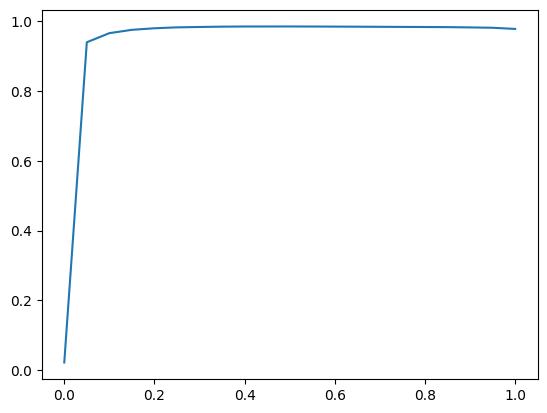

In [19]:
plt.plot(thresholds, scores)

#### Logistic Regression - Confusion Matrix

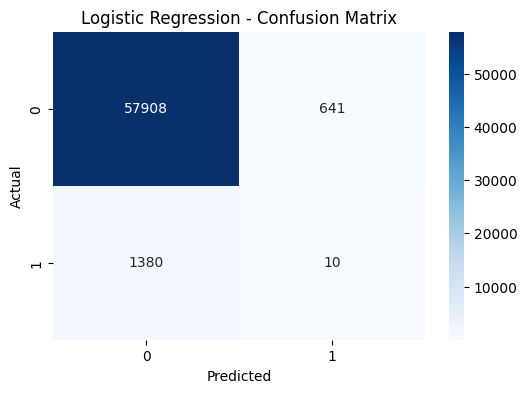

In [20]:
cmatrix = confusion_matrix(y_test, model.predict(X_val))
plt.figure(figsize=(6, 4))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression - Precision and Recall

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [22]:
# Precision
tp / (tp + fp)

np.float64(0.8233486943164362)

In [23]:
# Recall
tp / (tp + fn)

np.float64(0.4148606811145511)

#### Logistic Regression - ROC Curve

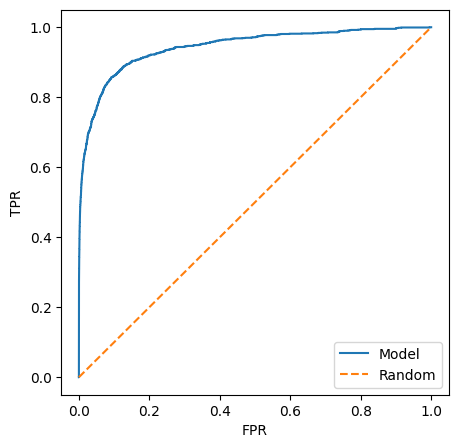

In [24]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

#### Logistic Regression - ROC AUC

In [25]:
lg_score = roc_auc_score(y_val, y_pred)
lg_score

0.9433610264403474

## Random forest

#### Parameter tuning

In [26]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.928516
1,20,0.944417
2,30,0.953849
3,40,0.956058
4,50,0.958318
5,60,0.959155
6,70,0.961666
7,80,0.963208
8,90,0.964525
9,100,0.964613


In [27]:
n_estimators = 200
scores = []

for d in [5, 10, 15]:
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=d,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((d, n_estimators, auc))

In [28]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,max_depth,n_estimators,auc
0,5,200,0.974048
1,10,200,0.978453
2,15,200,0.977919


In [29]:
max_depth = 10

scores = []

for s in [1, 3, 5, 10, 50]:
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=s,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((s, n_estimators, auc))

In [30]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,min_samples_leaf,n_estimators,auc
0,1,200,0.978453
1,3,200,0.977697
2,5,200,0.978683
3,10,200,0.978108
4,50,200,0.978356


In [31]:
min_samples_leaf = 5

rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
rf_score = roc_auc_score(y_val, y_pred)
rf_score

0.978682882593822

## XGBoost

In [32]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [33]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = model.predict(dval)

roc_auc_score(y_val, y_pred)

0.9758971278068642

#### XGBoost parameter tuning

In [34]:
scores = []

for e in [0.1, 0.3, 0.5, 1]:
    xgb_params = {
        'eta': e, 
        'max_depth': 3,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((e, 3, 1, auc))

In [35]:
columns = ['eta', 'max_depth', 'min_child_weight', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,eta,max_depth,min_child_weight,auc
0,0.1,3,1,0.972887
1,0.3,3,1,0.968869
2,0.5,3,1,0.861359
3,1.0,3,1,0.743645


In [36]:
eta = 0.1

In [37]:
scores = []

for m in [3, 6, 9, 12]:
    xgb_params = {
        'eta': eta, 
        'max_depth': m,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((eta, m, 1, auc))

In [38]:
columns = ['eta', 'max_depth', 'min_child_weight', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,eta,max_depth,min_child_weight,auc
0,0.1,3,1,0.972887
1,0.1,6,1,0.975897
2,0.1,9,1,0.976126
3,0.1,12,1,0.974049


In [39]:
max_depth = 9

In [40]:
scores = []

for m in [1, 3, 6, 9, 12]:
    xgb_params = {
        'eta': eta, 
        'max_depth': max_depth,
        'min_child_weight': m,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((eta, max_depth, m, auc))

In [41]:
columns = ['eta', 'max_depth', 'min_child_weight', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,eta,max_depth,min_child_weight,auc
0,0.1,9,1,0.976126
1,0.1,9,3,0.976734
2,0.1,9,6,0.976633
3,0.1,9,9,0.977050
4,0.1,9,12,0.975529


In [42]:
min_child_weight = 9

In [43]:
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = model.predict(dval)

xgb_score = roc_auc_score(y_val, y_pred)
xgb_score

0.97704968531616

## Selecting the final model

In [44]:
auc_scores = []
auc_scores.append(('Logistic Regression', lg_score))
auc_scores.append(('Random Forest', rf_score))
auc_scores.append(('XGBoost', xgb_score))

columns = ['Model', 'roc_auc_score']
df_scores = pd.DataFrame(auc_scores, columns=columns)

df_scores

,Model,roc_auc_score
0,Logistic Regression,0.943361
1,Random Forest,0.978683
2,XGBoost,0.977050


In [45]:
df_scores.loc[df_scores.roc_auc_score.idxmax()]

Model            Random Forest
roc_auc_score         0.978683
Name: 1, dtype: object

The best tuned parameters of the **Random Forest model**

In [46]:
print('n_estimators: ', n_estimators)
print('max_depth: ', max_depth)
print('min_samples_leaf: ', min_samples_leaf)

n_estimators:  200
max_depth:  9
min_samples_leaf:  5


Final check of the **Random Forest model** on full and test datasets

In [47]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.is_fraud.values
del df_full_train['is_fraud']

In [48]:
dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [49]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=1)
rf.fit(X_full_train, y_full_train)

y_pred = rf.predict_proba(X_test)[:, 1]
rf_score = roc_auc_score(y_test, y_pred)
rf_score

0.9689395502334575